In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(13847942484)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
print(survivalstan.models.pem_survival_model_timevarying)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // data
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 obs_t      = observed end time for interval for timepoint for that obs
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>

functions {
  matrix spline(vector x, int N, int H, vector xi, int P) {
    matrix[N, H + P] b_x;         // expanded predictors
    for (n in 1:N) {
        for (p in 1:P) {
            b_x[n,p] <- pow(x[n],p-1);  // x[n]^(p-1)
        }
        for (h in 1:H)
          b_x[n, h + P] <- fmax(0, pow(x[n] - xi[h],P-1)); 
    }
    return b_x;
  }
}
data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
 

In [3]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


,age,sex,rate,true_t,t,event,index,age_centered
0,56,male,0.082085,3.690371,3.690371,True,0,0.61
1,53,male,0.082085,1.574213,1.574213,True,1,-2.39
2,43,male,0.082085,29.095240,20.000000,False,2,-12.39
3,50,male,0.082085,1.017584,1.017584,True,3,-5.39
4,45,male,0.082085,40.317564,20.000000,False,4,-10.39


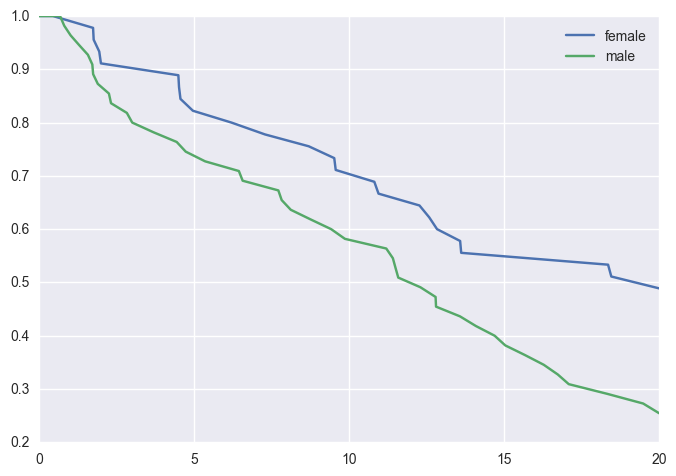

In [4]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [5]:
dlong = survivalstan.prep_data_long_surv(df=d, event_col='event', time_col='t')

In [6]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
0,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,3.690371,True
1,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.574213,False
3,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.017584,False
7,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.292124,False
8,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.743126,False


In [7]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model_timevarying,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_72587862687.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_72587862687.pystan_2_12_0_0.stanfit.chains_4.data_48760636088.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution


KeyboardInterrupt: 

In [ ]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

In [ ]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline')

In [ ]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

In [ ]:
survivalstan.utils.plot_coefs([testfit])

In [ ]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

In [ ]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')

In [ ]:
survivalstan.utils.plot_pp_survival([testfit], by='sex', pal=['red', 'blue'])
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t',
                                          color='red', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t',
                                          color='blue', label='male')
plt.legend()